In [1]:
import utils_BudykoSellers
import utils_emulator
import utils_plots
import utils_cubic_Lorenz
import numpy as np

%load_ext autoreload
%autoreload 2

/Users/chriswomack/Documents/PhD/Project 1/utils_plots.py:767: SyntaxWarning: invalid escape sequence '\i'
  fig.suptitle(f'NRMSE vs. Ensemble size by method\nTraining scenario: $\it{{{train}}}$',fontsize=24)


# Create plots shown in manuscript

Code to produce Figure 1 was produced by Shahine Bouabid and can be found in 'utils_plot_fig01/'. This code requires data from the MPI Grand Ensemble for ScenarioMIP to run. Figure 1 is formatted in Adobe Illustrator.

Figure 2 is created partially by this notebook and partially by Adobe Illustrator

## Figure 2: Conceptual overview of emulators

### 1. Run all scenarios for the three box model

In [2]:
# Required variables
t_end     = 251
t         = np.arange(0,t_end)
n_boxes   = 3
diff_flag = 1

# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi         = 1.25 # Noise strength

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Plateau','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble, std_ensemble, mean_ensemble = {}, {}, {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs_ensemble[scen], forcings_ensemble[scen], T_out_ensemble[scen] = [], [] ,[]

  # Run deterministic scenarios once
  full_outputs_single[scen] = utils_BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes, diff_flag=1)
  forcings_single[scen] = np.tile(full_outputs_single[scen]['forcing_ts'], (n_boxes, 1))
  T_out_single[scen] = np.squeeze(full_outputs_single[scen]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[scen].append(utils_BudykoSellers.Run_Budyko_Sellers(scen_flag=i, xi=xi, n_boxes=n_boxes, diff_flag=1))
    forcings_ensemble[scen].append(np.tile(full_outputs_ensemble[scen][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[scen].append(np.squeeze(full_outputs_ensemble[scen][-1]['T_ts'])[0:n_boxes,:])

  mean_ensemble[scen] = np.mean(np.array(T_out_ensemble[scen]),axis=0)
  std_ensemble[scen] = np.std(np.array(T_out_ensemble[scen]),axis=0)

/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### 2. Produce Plots

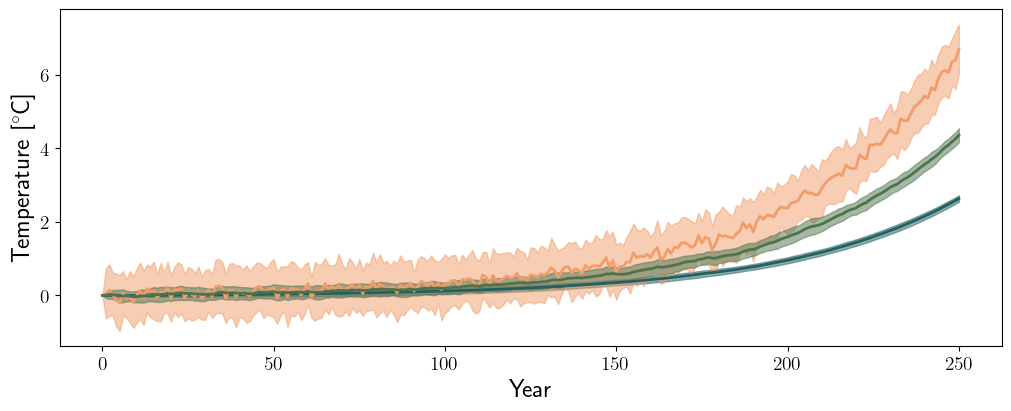

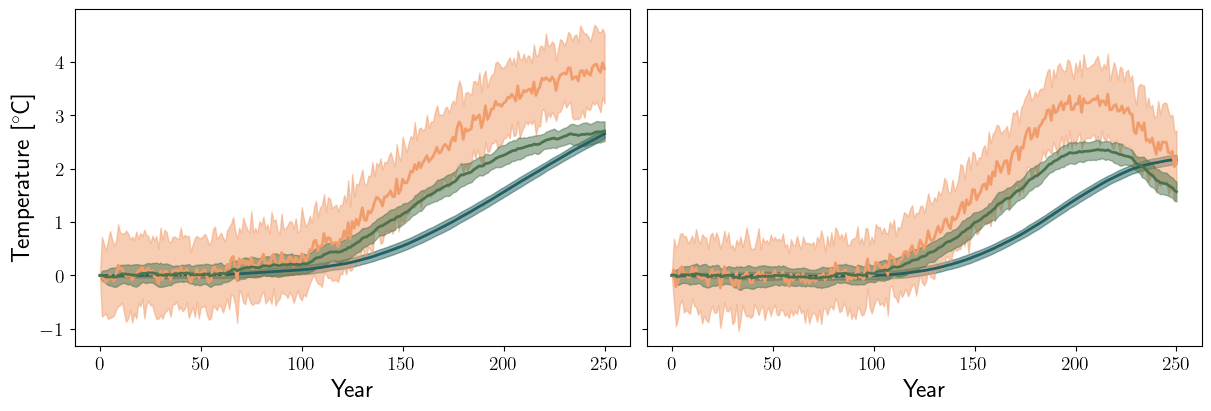

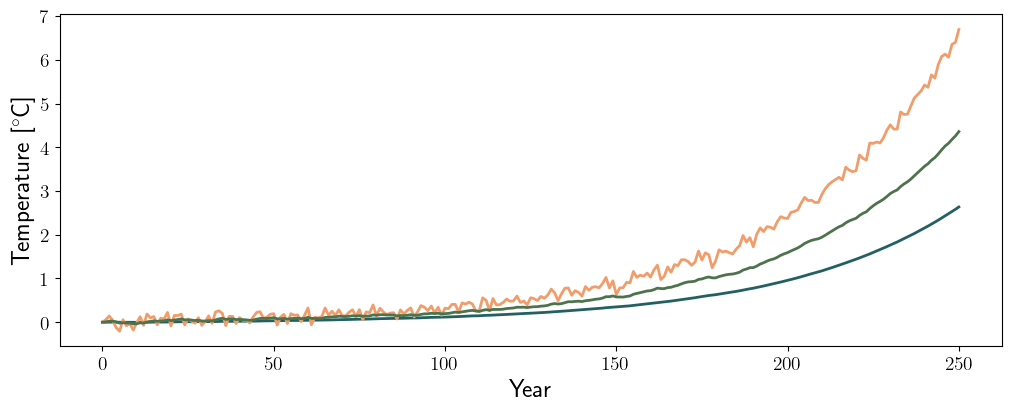

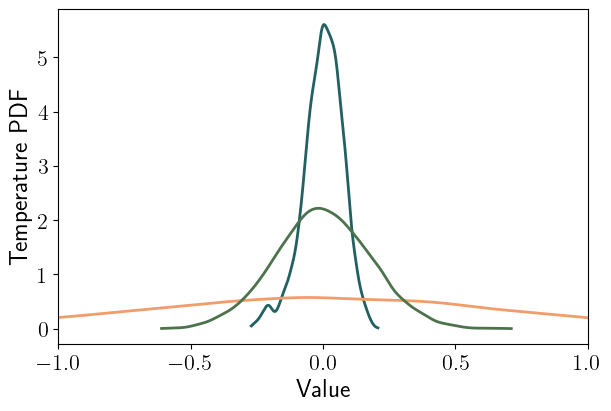

In [4]:
save_fig = False

# Plot baseline scenario w/ uncertainty
scen = 'High Emissions'
fig_name2a = 'fig02a'
utils_plots.plot_baseline_fig2(scen, mean_ensemble, std_ensemble, t, save_fig=save_fig, fig_name=fig_name2a)

# Plot alternate scenarios w/ uncertainty
scens = ['Plateau', 'Overshoot']
fig_name2b = 'fig02b'
utils_plots.plot_alt_fig2(scens, mean_ensemble, std_ensemble, t, save_fig=save_fig, fig_name=fig_name2b)

# Plot only mean of baseline scenario
fig_name2c = 'fig02c'
utils_plots.plot_baseline_fig2(scen, mean_ensemble, std_ensemble, t, only_mean=True, save_fig=save_fig, fig_name=fig_name2c)

# Plot distribution of baseline scenario
fig_name2d = 'fig02d'
utils_plots.plot_pdf_fig2(scen, T_out_ensemble, save_fig=save_fig, fig_name=fig_name2d)

## Figure 3: Scenario overview by experiment

### 1. Run all scenarios for the two and three box models

In [5]:
# Required variables
t_end   = 251
t       = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run scenarios
experiments = ['3box_coup','2box_coup']
scenarios   = ['Abrupt','High Emissions','Plateau','Overshoot']
regions     = ['High Lat. Ocean','Land','Low Lat. Ocean']
full_outputs, T_out, forcings = {}, {}, {}

for i, exp in enumerate(experiments):
  T_out[exp], forcings[exp] = {}, {}

  #n_boxes = run_all_exp.get_num_boxes(i)
  if exp == '2box_coup':
    n_boxes = 2

  # Horizontally coupled vs. not
  if i == 0:
    diff_flag = 1
  else:
    diff_flag = 0

  # Vertically coupled vs not
  if i == 1:
    vert_diff_flag = 1
  else:
    vert_diff_flag = 0
  for j, scen in enumerate(scenarios):
    full_outputs[scen]  = utils_BudykoSellers.Run_Budyko_Sellers(scen_flag=j, n_boxes=n_boxes, diff_flag=diff_flag, vert_diff_flag=vert_diff_flag)
    forcings[exp][scen] = np.tile(full_outputs[scen]['forcing_ts'], (n_boxes, 1))
    T_out[exp][scen]    = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### 2. Run all scenarios for cubic Lorenz problem

In [7]:
# Lorenz parameters
sigma, beta  = 10.0, 8/3
rho_base     = 28.0
dt           = 0.01
delta_rho    = 1.0/dt
alpha        = 1/1000
t_max_pert   = 5
t_max_scen   = 250
t_vec_pert   = np.arange(0.0, t_max_pert + dt, dt)
t_vec_scen   = np.arange(0.0, t_max_scen + dt, dt)
n_steps_pert = t_vec_pert.size
n_steps_scen = t_vec_scen.size
n_ensemble   = 5_000
eps          = 4
scenarios    = ['Abrupt','High Emissions','Plateau','Overshoot']
rho          = utils_cubic_Lorenz.gen_rho(t_vec_scen, scenarios)

state0, baseline_mean       = utils_cubic_Lorenz.spin_up(n_ensemble, rho_base, sigma, alpha, beta, dt, eps)
state_ensemble, state_mean  = utils_cubic_Lorenz.run_Lorenz(scenarios, state0, n_ensemble, n_steps_scen, rho, sigma, alpha, beta, dt, eps)
z_ensemble, z_mean, z_std   = utils_cubic_Lorenz.get_z_vals(scenarios, open=False, state_ensemble=state_ensemble, state_mean=state_mean)

### 3. Create plot

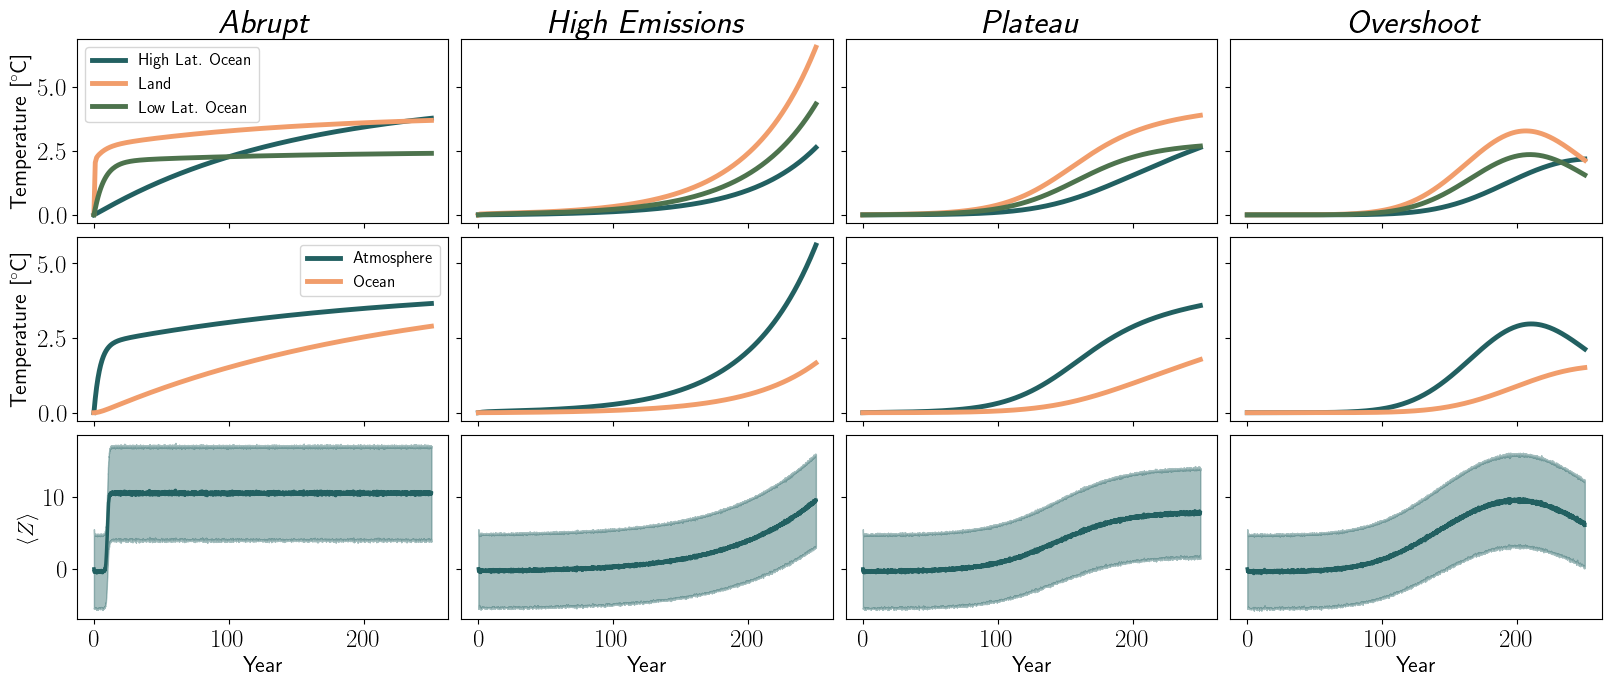

In [11]:
save_fig                = False
fig_name                = 'fig03'
experiments_plot        = ['3box_coup','2box_coup','cub_Lorenz']
T_out['cub_Lorenz']     = z_mean
t_vec_box, t_vec_lorenz = t, t_vec_scen
utils_plots.plot_scenarios(experiments_plot, scenarios, T_out, z_std, t_vec_box, t_vec_lorenz, regions, baseline_mean, save_fig=save_fig, fig_name=fig_name)

## Figure 4: Summary of emulator performance

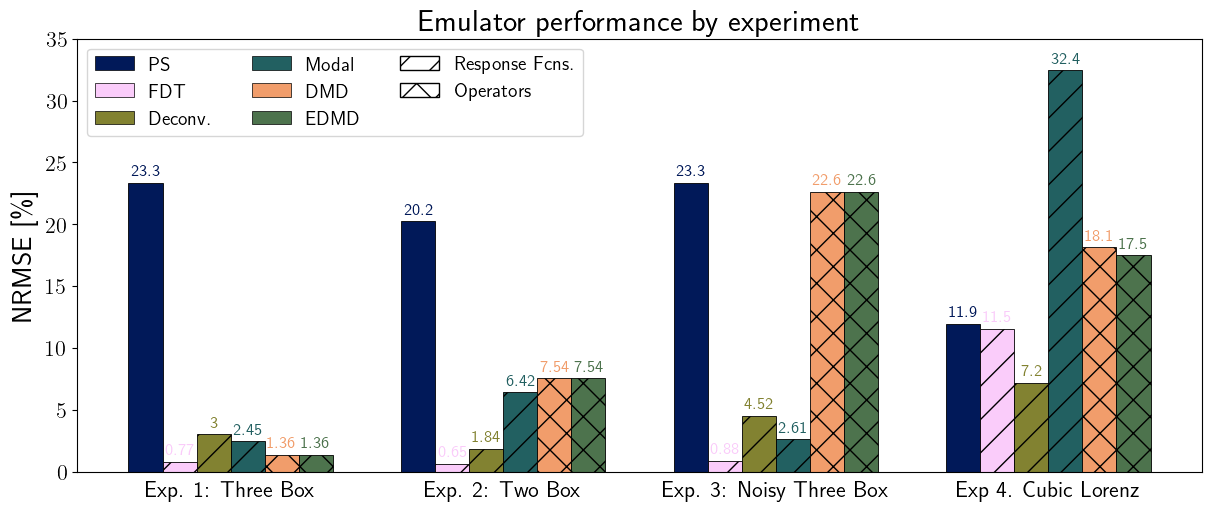

In [6]:
scenarios       = ['Abrupt','High Emissions','Plateau','Overshoot']
experiments     = ('Exp. 1: Three Box', 'Exp. 2: Two Box', 'Exp. 3: Noisy Three Box', 'Exp 4. Cubic Lorenz')
ensemble_index  = 39 # Index for plotting
all_errors      = utils_plots.get_error_by_method(scenarios, ensemble_index)
save_fig        = False
fig_name        = 'fig04'
utils_plots.plot_emulator_bars(experiments, all_errors, save_fig=save_fig, fig_name=fig_name)

## Figure 5: NRMSE heatmaps for experiment 1

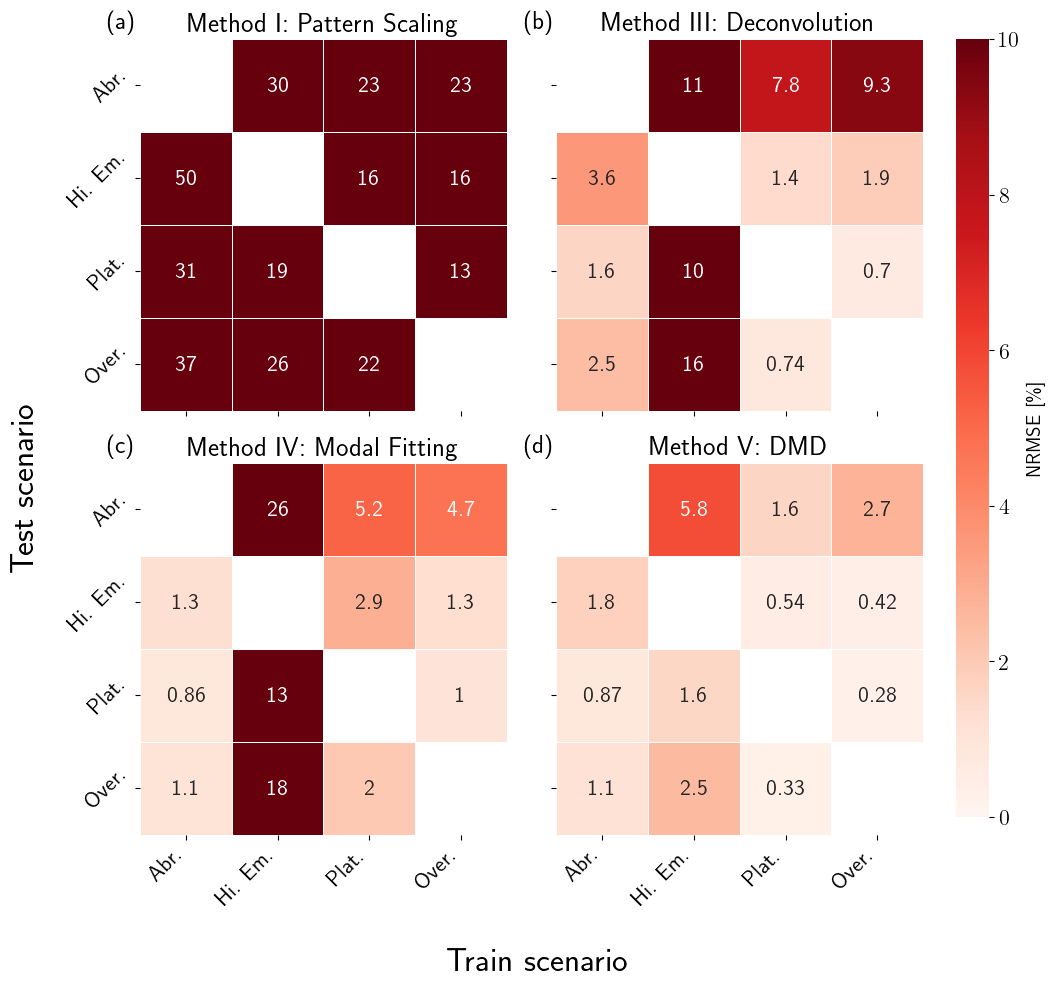

In [31]:
save_fig          = False
fig_name          = 'fig05'
scenarios         = ['Abrupt','High Emissions','Plateau','Overshoot']
methods_to_plot   = ["PS", "Deconv", "Modal", "DMD"]
titles_for_plots  = ["Method I: Pattern Scaling", "Method III: Deconvolution", "Method IV: Modal Fitting", "Method V: DMD"]

error_metrics_PS          = utils_emulator.open_results('exp1_I_PS_error')
error_metrics_deconvolve  = utils_emulator.open_results('exp1_III_deconv_error')
error_metrics_modal       = utils_emulator.open_results('exp1_IV_modal_error')
error_metrics_DMD         = utils_emulator.open_results('exp1_V_DMD_error')

error_metrics_all_exp1 = {
  'PS':error_metrics_PS,
  'Deconv':error_metrics_deconvolve,
  'Modal':error_metrics_modal,
  'DMD':error_metrics_DMD
}

utils_plots.plot_error_heatmap_grid(
  error_metrics=error_metrics_all_exp1,
  methods=methods_to_plot,
  titles=titles_for_plots,
  train_scenarios=scenarios,
  test_scenarios=scenarios,
  save_fig=save_fig,
  fig_name=fig_name
)

## Figure 6: Fluctuation Dissipation Theorem emulator performance

/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


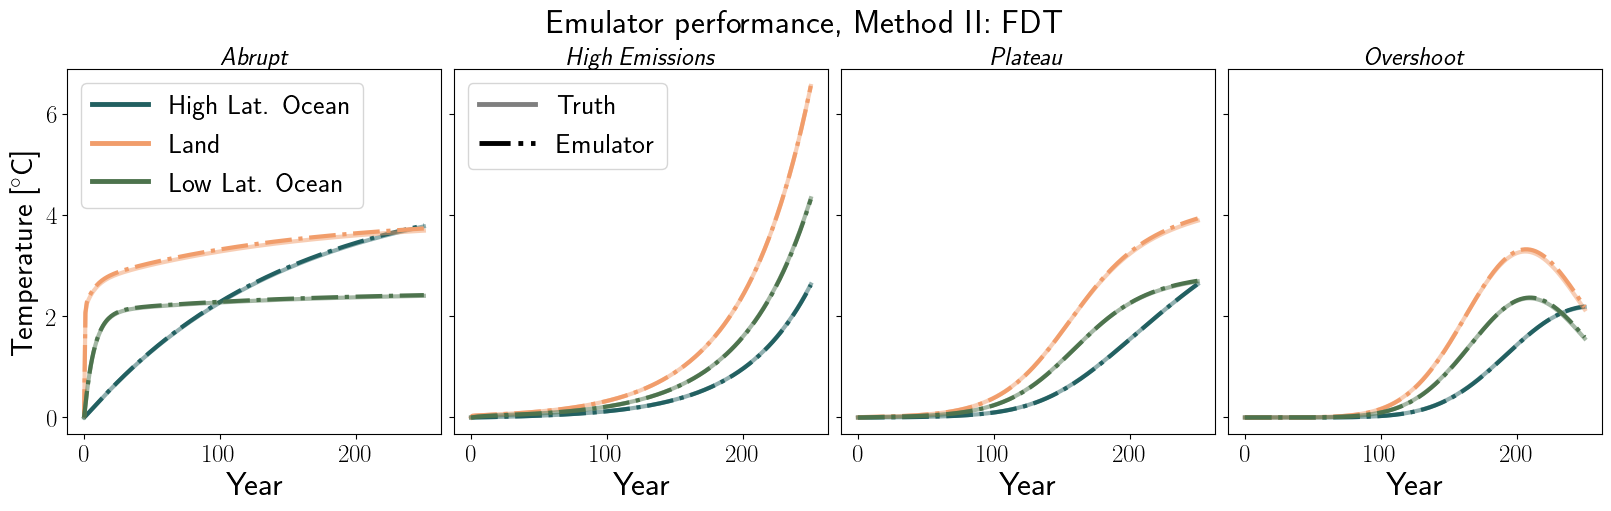

In [30]:
dt        = 1
exp       = '3box_coup'
n_boxes   = 3
save_fig  = False
fig_name  = 'fig06'

operator_FDT, T_pred_FDT, error_metrics_FDT = utils_emulator.emulate_scenarios('FDT', scenarios=scenarios, outputs=T_out[exp], forcings=forcings[exp], n_boxes=n_boxes, dt=dt, diff_flag=1, delta=1, verbose=False)
utils_plots.plot_box_true_pred(['3box_coup'], scenarios, T_out, T_pred_FDT, regions, save_fig=save_fig, fig_name=fig_name)

## Figure 7: NRMSE heatmaps for experiment 2

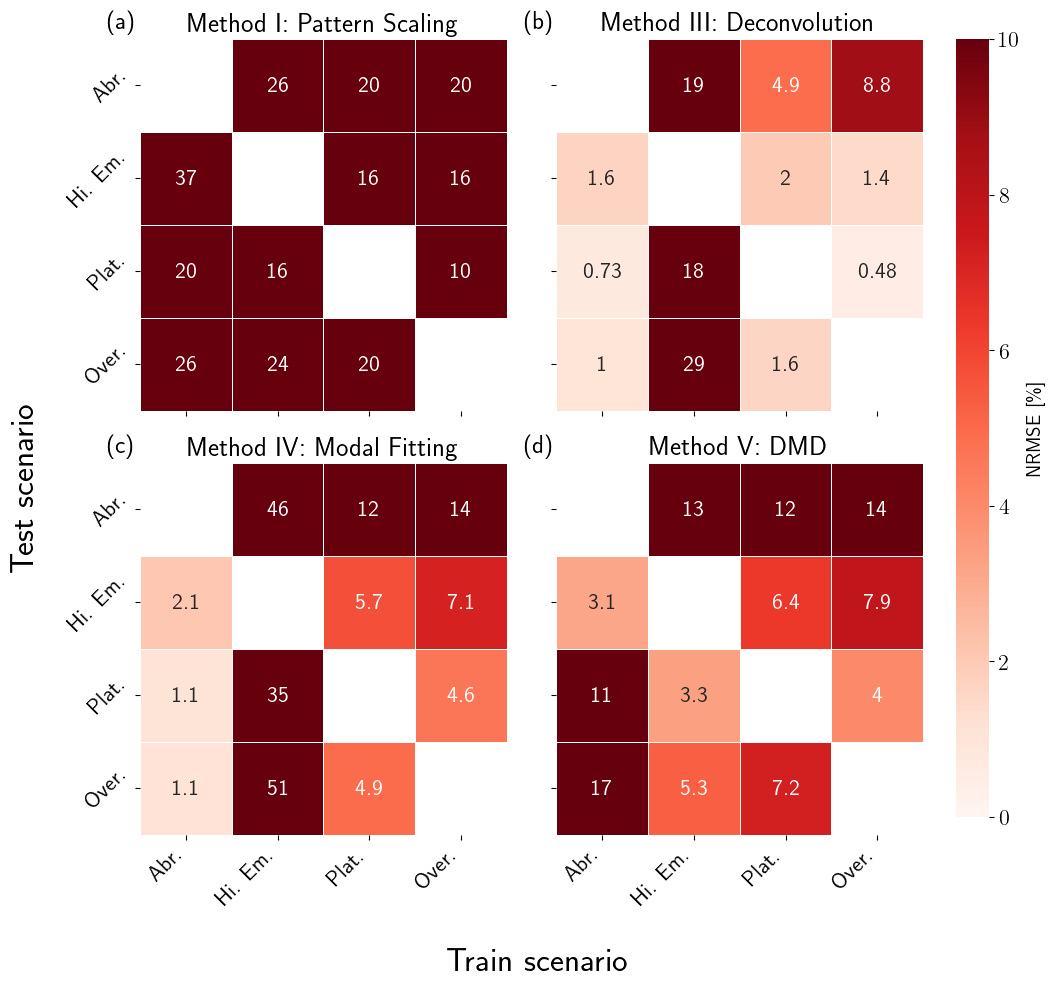

In [34]:
save_fig          = False
fig_name          = 'fig07'
scenarios         = ['Abrupt','High Emissions','Plateau','Overshoot']
methods_to_plot   = ["PS", "Deconv", "Modal", "DMD"]
titles_for_plots  = ["Method I: Pattern Scaling", "Method III: Deconvolution", "Method IV: Modal Fitting", "Method V: DMD"]

error_metrics_PS          = utils_emulator.open_results('exp2_I_PS_error')
error_metrics_deconvolve  = utils_emulator.open_results('exp2_III_deconv_error')
error_metrics_modal       = utils_emulator.open_results('exp2_IV_modal_error')
error_metrics_DMD         = utils_emulator.open_results('exp2_V_DMD_error')

error_metrics_all_exp2 = {
  'PS':error_metrics_PS,
  'Deconv':error_metrics_deconvolve,
  'Modal':error_metrics_modal,
  'DMD':error_metrics_DMD
}

utils_plots.plot_error_heatmap_grid(
  error_metrics=error_metrics_all_exp2,
  methods=methods_to_plot,
  titles=titles_for_plots,
  train_scenarios=scenarios,
  test_scenarios=scenarios,
  cmap="Reds",
  save_fig=save_fig,
  fig_name=fig_name
)

## Figure 8: NRMSE vs. number of ensemble members for experiment 3

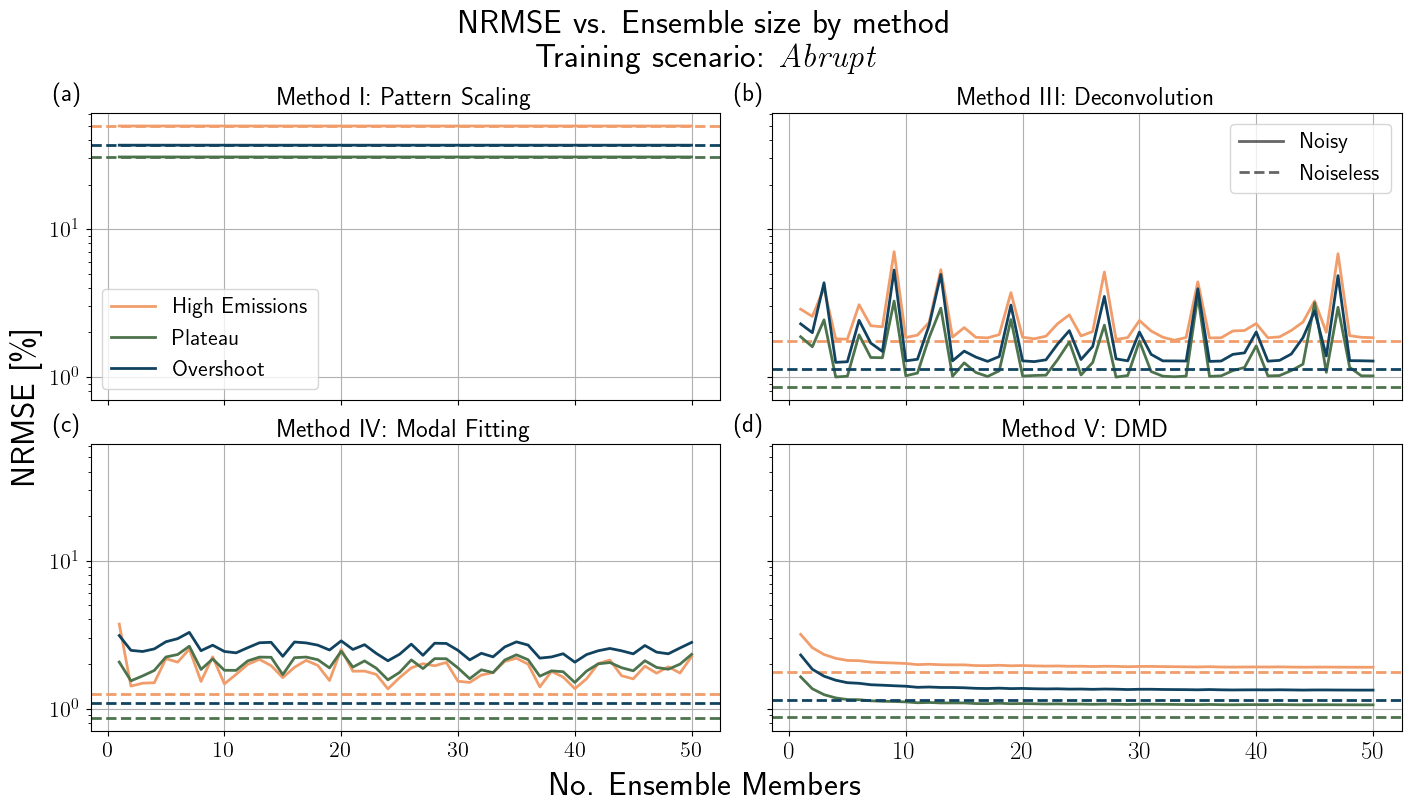

In [3]:
NRMSE_all_PS, NRMSE_base_PS         = utils_emulator.open_results('exp3_I_PS_error_ensemble'), utils_emulator.open_results('exp3_I_PS_error_single')
NRMSE_all_deconv, NRMSE_base_deconv = utils_emulator.open_results('exp3_III_deconv_error_ensemble'), utils_emulator.open_results('exp3_III_deconv_error_single')
NRMSE_all_modal, NRMSE_base_modal   = utils_emulator.open_results('exp3_IV_modal_error_ensemble'), utils_emulator.open_results('exp3_IV_modal_error_single')
NRMSE_all_DMD, NRMSE_base_DMD       = utils_emulator.open_results('exp3_V_DMD_error_ensemble'), utils_emulator.open_results('exp3_V_DMD_error_single')

NRMSE_all       = [NRMSE_all_PS, NRMSE_all_deconv, NRMSE_all_modal, NRMSE_all_DMD]
NRMSE_all_base  = [NRMSE_base_PS, NRMSE_base_deconv, NRMSE_base_modal, NRMSE_base_DMD]
scenarios       = ['Abrupt','High Emissions','Plateau','Overshoot']

methods = ['Method I: Pattern Scaling','Method III: Deconvolution',
           'Method IV: Modal Fitting', 'Method V: DMD']

train     = 'Abrupt'
save_fig  = False
fig_name  = 'fig08'
utils_plots.plot_ensemble_error_multi(NRMSE_all, NRMSE_all_base, scenarios, methods, train, save_fig=save_fig, fig_name=fig_name)

## Figure 9: NRMSE vs number of ensemble members for experiment 4

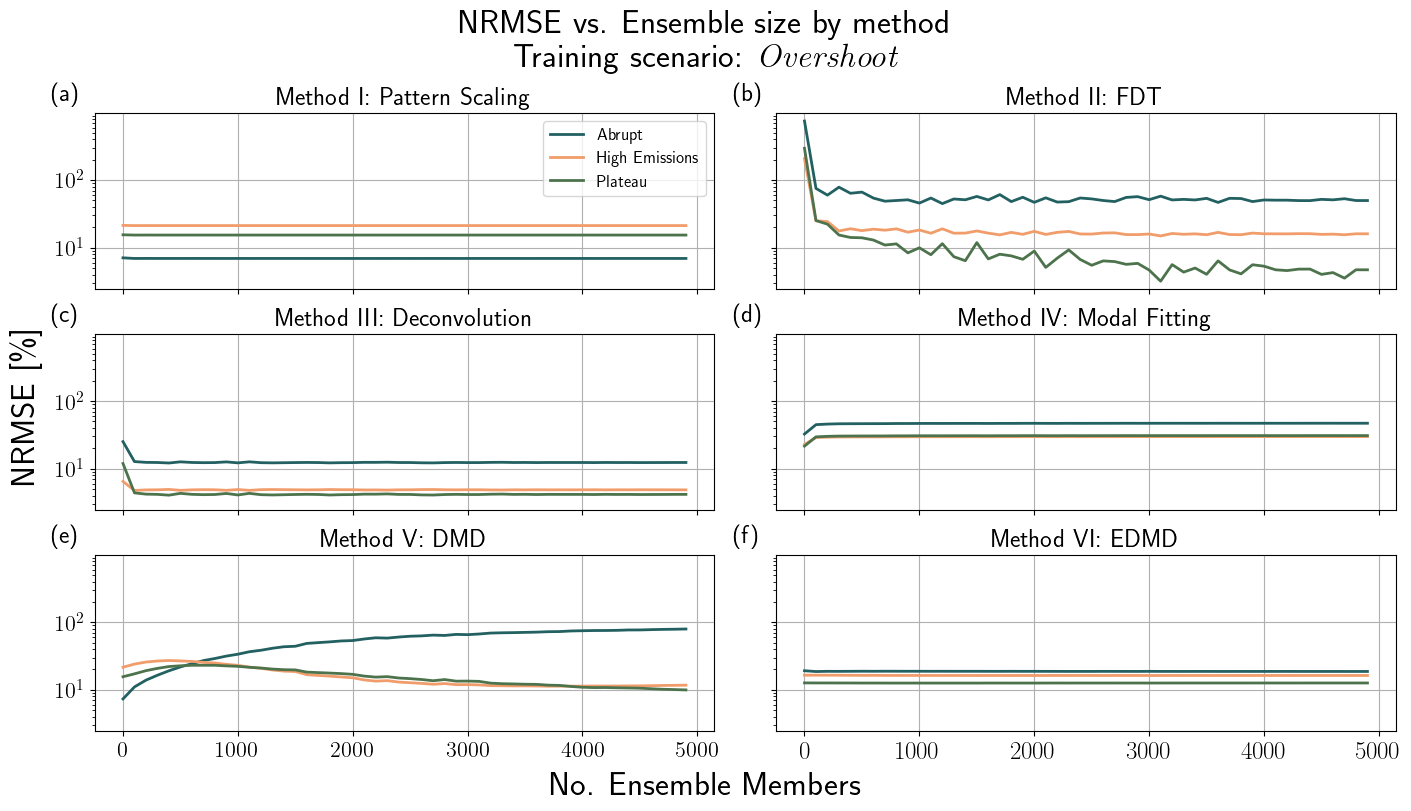

In [3]:
NRMSE_all_PS      = utils_emulator.open_results('exp4_I_PS_error_ensemble')
NRMSE_all_FDT     = utils_emulator.open_results('exp4_II_FDT_error_ensemble')
NRMSE_all_deconv  = utils_emulator.open_results('exp4_III_deconv_error_ensemble')
NRMSE_all_modal   = utils_emulator.open_results('exp4_IV_modal_error_ensemble')
NRMSE_all_DMD     = utils_emulator.open_results('exp4_V_DMD_error_ensemble')
NRMSE_all_EDMD    = utils_emulator.open_results('exp4_VI_EDMD_error_ensemble')

NRMSE_all = [NRMSE_all_PS, NRMSE_all_FDT, NRMSE_all_deconv, NRMSE_all_modal, NRMSE_all_DMD, NRMSE_all_EDMD]
scenarios = ['Abrupt','High Emissions','Plateau','Overshoot']
methods   = ['Method I: Pattern Scaling','Method II: FDT', 'Method III: Deconvolution',
             'Method IV: Modal Fitting', 'Method V: DMD', 'Method VI: EDMD']

train     = 'Overshoot'
save_fig  = False
fig_name  = 'fig09'
utils_plots.plot_ensemble_error_multi(NRMSE_all, None, scenarios, methods, train, cubLor=True, save_fig=save_fig, fig_name=fig_name)

## Figure 10: Response function for cubic Lorenz system

NRMSE 50k vs 5k: [166.22055014]
NRMSE 50k vs 500: [546.05577537]


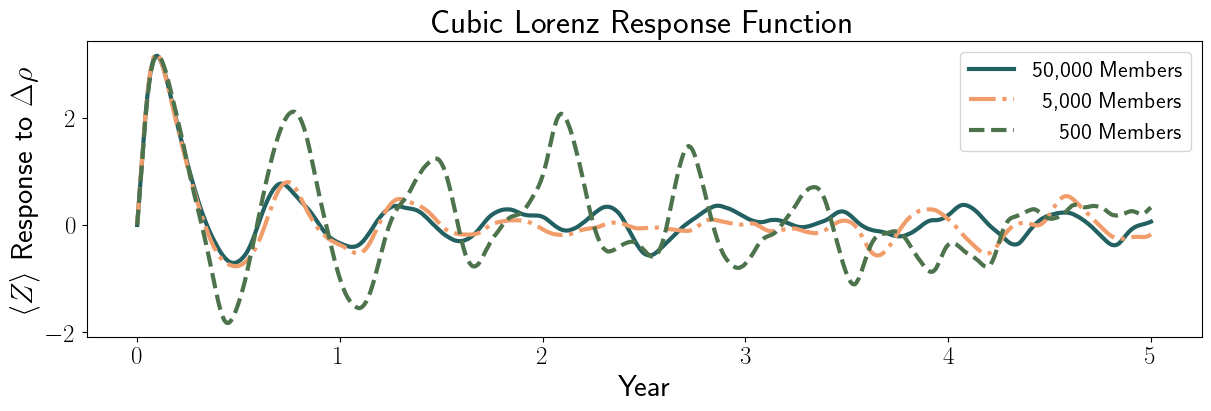

In [74]:
state0_5k    = utils_emulator.open_results('exp4_state0')[0:5_000,:]
state0_500   = utils_emulator.open_results('exp4_state0')[0:500,:]
sigma, beta  = 10.0, 8/3
rho_base     = 28.0
dt           = 0.01
delta_rho    = 1.0/dt
alpha        = 1/1000
t_max_pert   = 5
t_vec_pert   = np.arange(0.0, t_max_pert + dt, dt)
n_steps_pert = t_vec_pert.size
eps          = 4
R_50k        = utils_emulator.open_results('R_mean')
R_5k         = utils_cubic_Lorenz.run_Lorenz_pert(state0_5k, 5_000, n_steps_pert, rho_base, sigma, alpha, beta, dt, eps)
R_500        = utils_cubic_Lorenz.run_Lorenz_pert(state0_500, 500, n_steps_pert, rho_base, sigma, alpha, beta, dt, eps)
save_fig     = False
fig_name     = 'fig10'

utils_plots.plot_Lorenz_response(R_50k, R_5k[0][:,2], R_500[0][:,2], t_vec_pert, save_fig=save_fig, fig_name=fig_name)

print(f'NRMSE 50k vs 5k: {utils_emulator.calc_NRMSE(R_50k.reshape(1,-1), R_5k[0][:,2])}')
print(f'NRMSE 50k vs 500: {utils_emulator.calc_NRMSE(R_50k.reshape(1,-1), R_500[0][:,2])}')